# Исследование прибыльности тарифов сотового оператора

## Введение

### Цель проекта

Цель проекта состоит в сравнении доходности разных тарифов оператора сотовой связи для дальнейшей оптимизации рекламных бюджетов. Необходимо проверить две гипотезы на уровне значимости в 5%:

- средняя выручка с пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка с пользователей из Москвы отличается от выручки с пользователей других регионов.

Для реализации поставленной задачи следует:
- Проанализировать данные на предмет их полноты. По необходимости устанить проблемы в данных (пропуски, дубликаты, аномалии и т.п.);
- По необходимости подготовить признаки для исследования (агрегировать данные, расчитать средние значения и т.п.);
- Сравнить пользователей разных тарифов по основным поведенческим характеристикам;
- Сформулировать гипотезы для проверки и провести статистические тесты.

### Общий контекст

Оператор "Мегалайн" предлагает два тарифа: "Смарт" и "Ультра".  Основные характеристики тарифов:

| Характеристика | "Смарт" | "Ультра" |
| :---------------------- | :---------------------- | :---------------------- |
|Ежемесячная плата, руб.|550|1950|
|**Включено в пакет:**|||
|Минуты|500|3000|
|SMS|50|1000|
|Интернет, ГБ|15|30|
|**Стоимость сверх пакета, руб:**|||
|1 минута|3|1|
|1 SMS|3|1|
|1 ГБ|200|150|

Для анализа доступна выборка по 500 клиентам за 2018 г. Данные предоставлены в виде пяти файлов:
- Информация о пользователях;
- Данные о звонках, смс и использовании интернет-трафика (3 файла);
- Характеристики тарифов.

In [1]:
# Импорты используемых библиотек:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

## Обзор данных

Загрузим данные, рассмотрим их состав. Начнем с данных по звонкам:

In [2]:
# Файл с информацией по звонкам:
try:
    calls = pd.read_csv('/datasets/calls.csv')
except:
    calls = pd.read_csv('datasets/telecom_tariffs/calls.csv')

print(calls.info())
display(calls.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Файл содержит информацию об id звонка, id клиента, дате звонка и его продолжительности. В файле представлено ок. 200 тыс. наблюдений. Рассмотрим распределение продолжительности звонков:

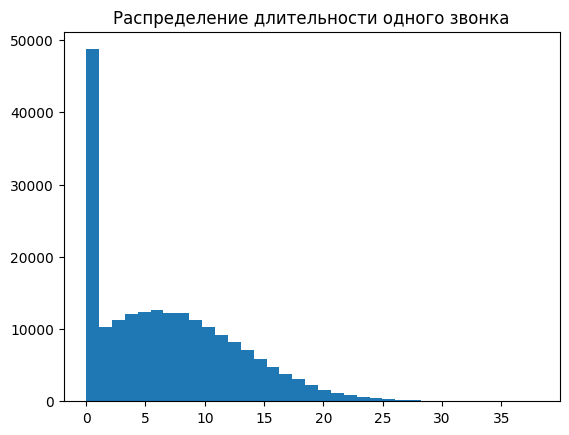

In [3]:
calls['duration'].hist(bins=35, grid=False)
plt.title('Распределение длительности одного звонка');

Есть всплеск на распределении на уровне нуля: нулем обозначены пропущенные вызовы. В остальном распределение выглядит нормально.

Рассмотрим информацию об использовании Интернет-трафика:

In [4]:
# Файл с информацией по трафику:
try:
    sessions = pd.read_csv('/datasets/internet.csv')
except:
    sessions = pd.read_csv('datasets/telecom_tariffs/internet.csv')

print(sessions.info())
display(sessions.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Имеется ок. 150 тыс. наблюдений. Файл имеет ту же структуру, что и данные о звонках: вместо длительности разговора указан использованный за сессию трафик в МБ. Также есть столбец, дублирующий индекс (`Unnamed: 0`). Рассмотрим распределение использованных мегабайт за сессию:

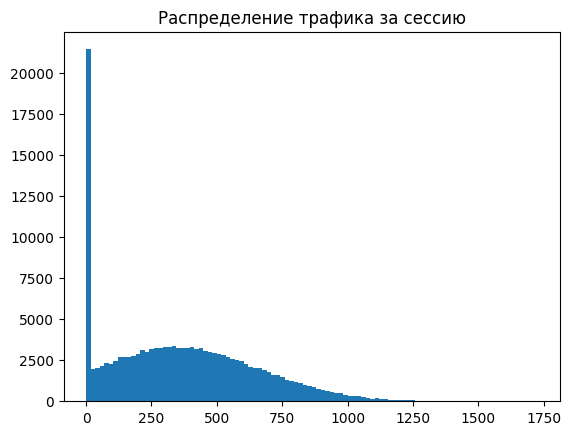

In [5]:
# Распределение трафика:
sessions['mb_used'].hist(bins=100, grid=False)
plt.title('Распределение трафика за сессию');

Как и в случае со звонками, есть существенный всплеск на уровне нулевых значений.

Перейдем к рассмотрению информации об смс:

In [6]:
# Файл с информацией по СМС:
try:
    messages = pd.read_csv('/datasets/messages.csv')
except:
    messages = pd.read_csv('datasets/telecom_tariffs/messages.csv')

print(messages.info())
display(messages.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Каждая запись в файле означает отправку одного смс с указанием id смс, id клиента и даты отправки сообщения. Всего в файле ок. 123 тыс. наблюдений.

Перейдем к информации о тарифах:

In [7]:
# Файл с информацией по тарифам:
try:
    tariffs = pd.read_csv('/datasets/tariffs.csv')
except:
    tariffs = pd.read_csv('datasets/telecom_tariffs/tariffs.csv')

tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Файл содержит всего две строки, обозначающие характеристики тарифов "Смарт" и "Ультра". 

Рассмотрим информацию о пользователях:

In [8]:
# Файл с информацией по пользователям:
try:
    users = pd.read_csv('/datasets/users.csv')
except:
    users = pd.read_csv('datasets/telecom_tariffs/users.csv')

print(users.info())
display(users.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


В файле представлена персональная информация о клиентах: возраст, город проживания, имя и фамилия, дата регистрации и подключенный тариф. Также есть 38 пользователей, разорвавших договор (`churn_rate`).

## Обработка данных

Во всех таблицах, кроме тарифов, имеются данные о датах (регистрации, совершения действия). Переведем их в формат даты (сейчас определены как строки).

In [9]:
# Конверитруем формат столбцов с датами:
users['reg_date'] = pd.to_datetime(users['reg_date']) 
users['churn_date'] = pd.to_datetime(users['churn_date']) 
calls['call_date'] = pd.to_datetime(calls['call_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
sessions['session_date'] = pd.to_datetime(sessions['session_date'])

Заметим также, что в столбце `duration` датафрейма `calls` значения дробные. По условиям тарификации разговор длиной даже в 1 секунду считается как целая минута. В связи с этим округлим значения вверх и приведем к целочисленному типу:

In [10]:
calls['duration'] = np.ceil(calls['duration']).astype('int')

Также удалим столбец `Unnamed: 0` из датафрейма `sessions` (избыточен, т.к. дублирует индекс):

In [11]:
sessions = sessions.drop(columns='Unnamed: 0')

Создадим в датафреймах о звонках, смс и трафике колонку, означающую месяц свершения операции (для дальнейшей группировки).

In [12]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
sessions['month'] = sessions['session_date'].dt.month

Теперь посчитаем число и длительность разговоров для каждого пользователя в месяц, а также количество использованных смс и интернет-трафика:

In [13]:
# подсчёт количества звонков для каждого пользователя по месяцам
calls_per_month = calls.groupby(['user_id', 'month']).agg(calls=('duration', 'count')) 
# подсчёт израсходованных минут для каждого пользователя по месяцам
minutes_per_month = calls.groupby(['user_id', 'month']).agg(minutes=('duration', 'sum'))
# подсчёт количества отправленных сообщений для каждого пользователя по месяцам
messages_per_month = messages.groupby(['user_id', 'month']).agg(messages=('message_date', 'count'))
# подсчёт потраченных мегабайт для каждого пользователя по месяцам
sessions_per_month = sessions.groupby(['user_id', 'month']).agg({'mb_used' : 'sum'}) 

## Анализ данных и подсчёт выручки

### Формирование показателей

В информации о пользователях содержался признак, расторгнул ли клиент договор. Найдем долю ушедших пользователей:

In [14]:
exited = users['churn_date'].count() / users['churn_date'].shape[0]
print(f'Договор расторгли {exited: .1%} клиентов.')

Договор расторгли  7.6% клиентов.


Ушедшие пользователи составляют менее 10% от датасета. Кроме того, параметр не влияет на сравнение поведения клиентов в зависимости от тарифа.

Для дальнейшего анализа объединим полученные данные датафрейм `user_behavior`. Для каждой пары "пользователь - месяц" будут доступны информация о тарифе, количестве звонков, сообщений и потраченных мегабайтах.

In [15]:
user_behavior = calls_per_month\
    .merge(messages_per_month, left_index=True, right_index=True, how='outer')\
    .merge(sessions_per_month, left_index=True, right_index=True, how='outer')\
    .merge(minutes_per_month, left_index=True, right_index=True, how='outer')\
    .reset_index()\
    .merge(users, how='left', left_on='user_id', right_on='user_id')\

user_behavior.head()

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,22.0,2253.49,159.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,43.0,60.0,23233.77,172.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,47.0,75.0,14003.64,340.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,52.0,81.0,14055.93,408.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,58.0,57.0,14568.91,466.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Проверим пропуски в таблице `user_behavior` после объединения:

In [16]:
user_behavior.isna().sum()

user_id          0
month            0
calls           40
messages       497
mb_used         11
minutes         40
age              0
churn_date    3027
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
dtype: int64

Пропуски означают, что в этом месяце пользователь не совершал операции, поэтому заполним образовавшиеся пропуски в данных нулями:

In [17]:
user_behavior['calls'] = user_behavior['calls'].fillna(0)
user_behavior['minutes'] = user_behavior['minutes'].fillna(0)
user_behavior['messages'] = user_behavior['messages'].fillna(0)
user_behavior['mb_used'] = user_behavior['mb_used'].fillna(0)

Присоединяем информацию о тарифах:

In [18]:
# для простоты переименуем столбец tariff_name на tariff

tariffs = tariffs.rename(
                        columns={'tariff_name': 'tariff'})
# присоединяем информацию о тарифе:
user_behavior = user_behavior.merge(tariffs, on='tariff')

Найдем количество минут разговора, сообщений и мегабайт, превышающих включенные в тариф:

In [19]:
# Найдем разницу между использованными и включенными; 
# если разница отрицательна - пользователь не вышел за лимит, заменим на 0
user_behavior['paid_minutes'] = user_behavior['minutes'] - user_behavior['minutes_included']
user_behavior['paid_messages'] = user_behavior['messages'] - user_behavior['messages_included']
user_behavior['paid_mb'] = user_behavior['mb_used'] - user_behavior['mb_per_month_included']

for col in ['paid_messages', 'paid_minutes', 'paid_mb']:
    user_behavior.loc[user_behavior[col] < 0, col] = 0

Переводим превышающие тариф мегабайты в гигабайты и сохраняем в столбец `paid_gb`:

In [20]:
user_behavior['paid_gb'] = np.ceil(user_behavior['paid_mb'] / 1024).astype(int)

Считаем выручку за минуты разговора, сообщения и интернет:

In [21]:
user_behavior['cost_minutes'] = user_behavior['paid_minutes'] * user_behavior['rub_per_minute']
user_behavior['cost_messages'] = user_behavior['paid_messages'] * user_behavior['rub_per_message']
user_behavior['cost_gb'] = user_behavior['paid_gb'] * user_behavior['rub_per_gb']

Считаем помесячную выручку с каждого пользователя, она будет храниться в столбец `total_cost`

In [22]:
user_behavior['total_cost'] = \
      user_behavior['rub_monthly_fee']\
    + user_behavior['cost_minutes']\
    + user_behavior['cost_messages']\
    + user_behavior['cost_gb']

Датафрейм `stats_df` для каждой пары "месяц-тариф" будет хранить основные характеристики

In [23]:
# сохранение статистических метрик для каждой пары месяц-тариф ...
# в одной таблице stats_df (среднее значение, стандартное отклонение, медиана)

stats_df = user_behavior.pivot_table(
            index=['month', 'tariff'],\
            values=['calls', 'minutes', 'messages', 'mb_used'],\
            aggfunc=['mean', 'std', 'median']\
).round(2).reset_index()

stats_df.columns=['month', 'tariff', 'calls_mean', 'sessions_mean', 'messages_mean', 'minutes_mean',
                                     'calls_std',  'sessions_std', 'messages_std', 'minutes_std', 
                                     'calls_median', 'sessions_median', 'messages_median',  'minutes_median']

stats_df.head(10)

,month,tariff,calls_mean,sessions_mean,messages_mean,minutes_mean,calls_std,sessions_std,messages_std,minutes_std,calls_median,sessions_median,messages_median,minutes_median
0,1,smart,27.68,8513.72,18.24,203.85,20.81,6444.68,16.20,154.23,20.5,7096.18,15.0,162.5
1,1,ultra,59.44,13140.68,33.78,428.11,41.64,6865.35,30.67,269.76,51.0,14791.37,32.0,382.0
2,2,smart,40.19,11597.05,24.09,298.69,25.39,6247.35,21.75,190.82,38.5,12553.71,20.0,258.0
3,2,ultra,41.54,11775.94,21.96,297.12,40.97,10644.64,26.77,296.51,25.0,7327.12,5.5,168.0
4,3,smart,54.32,15104.16,31.86,390.05,25.54,5828.24,26.80,191.89,59.0,15670.25,23.0,409.0
5,3,ultra,67.68,17535.55,32.30,489.65,44.84,10951.79,41.62,333.74,57.0,17495.18,20.0,403.0
6,4,smart,51.31,13462.18,30.74,367.13,25.70,5698.25,24.54,186.49,52.0,14087.65,28.0,368.5
7,4,ultra,64.09,16828.13,31.56,458.02,36.27,9718.65,37.51,267.68,61.0,16645.78,17.0,453.0
8,5,smart,55.24,15805.18,33.77,387.36,25.38,5978.23,27.04,186.60,59.0,16323.94,30.0,433.0
9,5,ultra,72.51,19363.15,37.85,510.33,41.08,10046.11,40.31,289.60,75.0,18696.43,25.0,519.0


### Анализ поведения клиентов

Рассмотрим распределение среднего количества звонков по месяцам в разрезе тарифов:

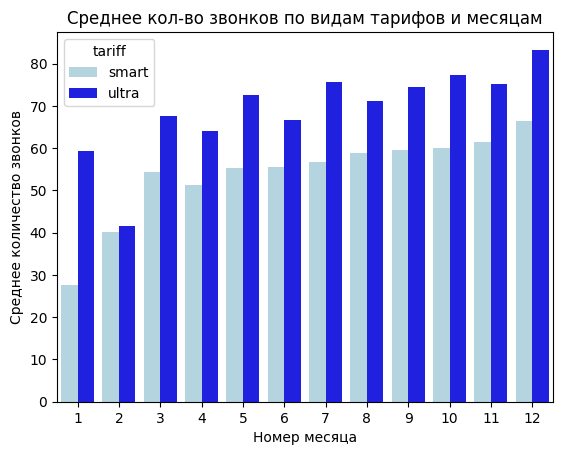

In [24]:
ax = sns.barplot(x='month',
            y='calls_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Среднее кол-во звонков по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество звонков');

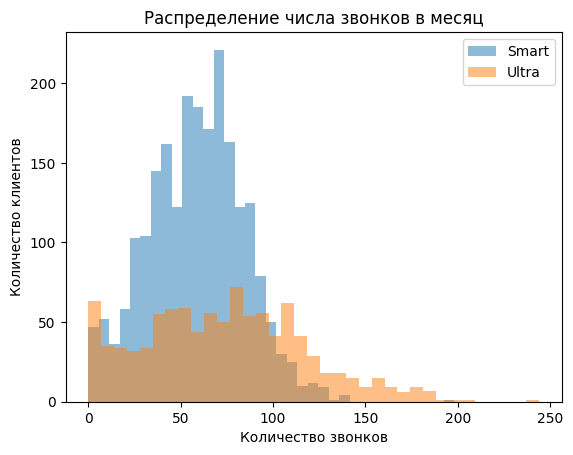

In [25]:
user_behavior.groupby('tariff')['calls'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество звонков')
plt.ylabel('Количество клиентов')
plt.title('Распределение числа звонков в месяц')
plt.show()

Среднее количество звонков клиентов "Смарт" меньше, чем у клиентов "Ультра". Тем не менее, среднее число растет для обоих видов пользователей от января к декабрю. При этом в целом по году распределение числа звонков более сконцентрированное для пользователей "Смарт".

Распределение длительности звонков по месяцам и тарифам:

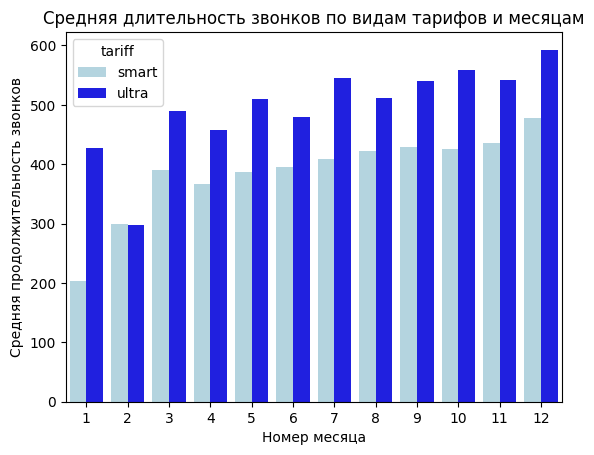

In [26]:
ax = sns.barplot(x='month',
            y='minutes_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Средняя длительность звонков по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Средняя продолжительность звонков');

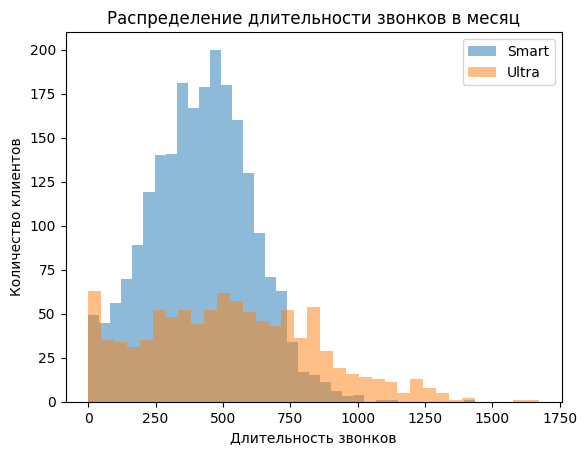

In [27]:
user_behavior.groupby('tariff')['minutes'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Длительность звонков')
plt.ylabel('Количество клиентов')
plt.title('Распределение длительности звонков в месяц')
plt.show()

Средняя длительность разговоров у абонентов тарифа "Ультра" больше, чем у абонентов тарифа "Смарт". В течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров. Рост средней длительности разговоров у абонентов тарифа "Смарт" равномерный в течение года, в то время как для пользователей "Ультра" это не справедливо. Стоит отметить, что феврале у абонентов обоих тарифных планов наблюдались самые низкие показатели.

Распределение среднего количества сообщений по видам тарифов и месяцам:

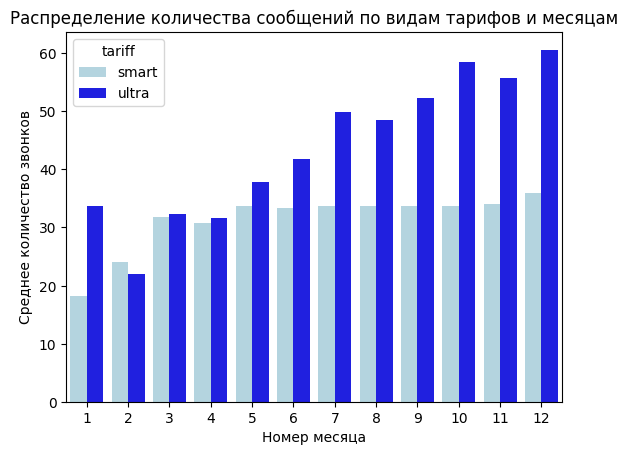

In [28]:
ax = sns.barplot(x='month',
            y='messages_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Распределение количества сообщений по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество звонков');

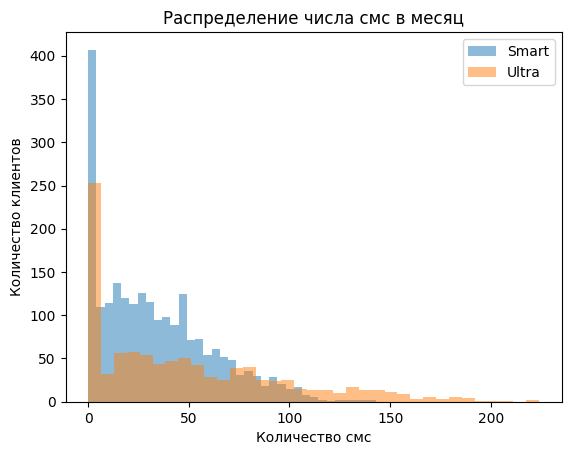

In [29]:
user_behavior.groupby('tariff')['messages'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество смс')
plt.ylabel('Количество клиентов')
plt.title('Распределение числа смс в месяц')
plt.show()

В среднем пользователи тарифа "Ультра" отправляют больше сообщений, чем пользователи тарифа "Смарт". Количество сообщений в течение года на обоих тарифах растет, хотя для пользователей тарифа "Смарт" динамика более пологая. При этом, как и с длительностью звонков, распределение для тарифа "Смарт" более сконцентрированное, нежели у клиентов тарифа "Ультра".

Рассмотрим использование интернет-трафика по месяцам:

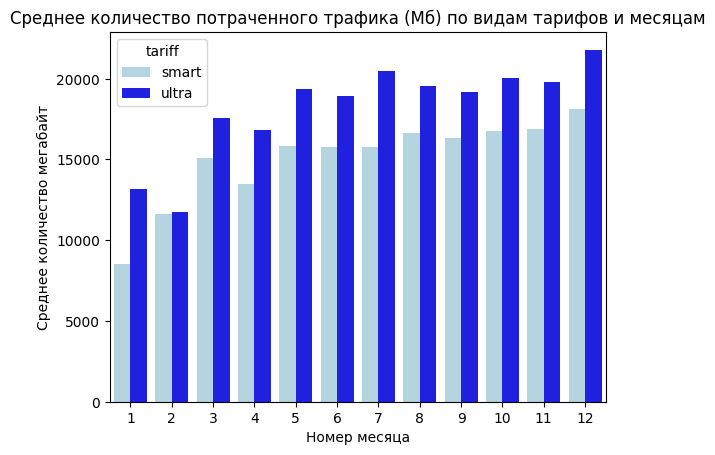

In [30]:
ax = sns.barplot(x='month',
            y='sessions_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Среднее количество потраченного трафика (Мб) по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество мегабайт');

Сравнение потраченных мегабайт среди пользователей тарифов "Смарт" и "Ультра":

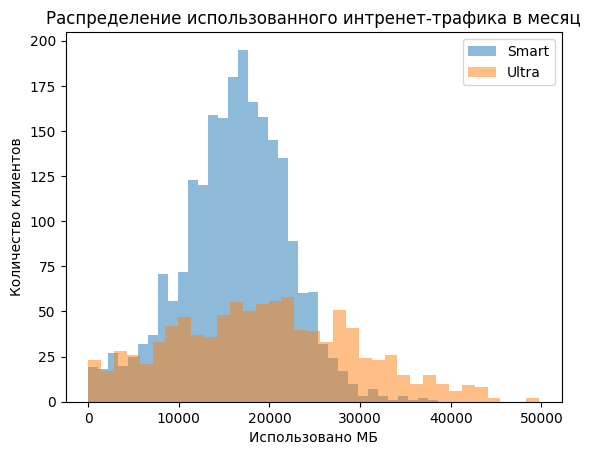

In [31]:
user_behavior.groupby('tariff')['mb_used'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Использовано МБ')
plt.ylabel('Количество клиентов')
plt.title('Распределение использованного интренет-трафика в месяц')
plt.show()

Меньше всего пользователи использовали интернет в январе, феврале и апреле. Чаще всего абоненты тарифа "Смарт" тратят 15-17 Гб, а абоненты тарифного плана "Ультра" - 19-21 ГБ.

## Проверка гипотез

Проверим гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. Сформулирем нулевую и альтернативкую гипотезы следующим образом:

```
H_0: Выручка (total_cost) пользователей "Ультра" = выручка (total_cost) пользователей "Смарт"`
H_a: Выручка (total_cost) пользователей "Ультра" ≠ выручка (total_cost) пользователей "Смарт"`
alpha = 0.05
```

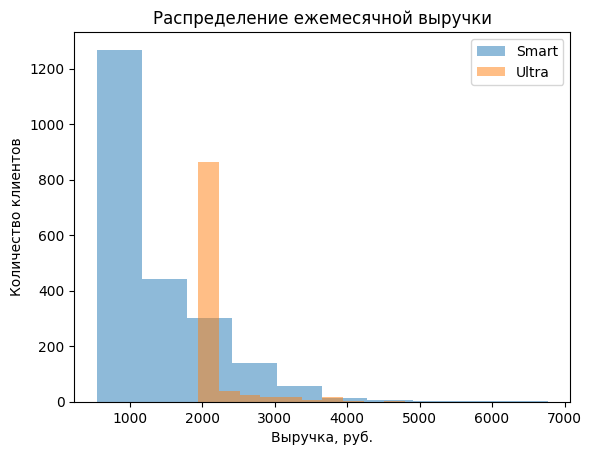

In [32]:
user_behavior.groupby('tariff')['total_cost'].plot(kind='hist', bins=10, alpha=0.5)
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Выручка, руб.')
plt.ylabel('Количество клиентов')
plt.title('Распределение ежемесячной выручки')
plt.show()

In [33]:
# Уровень значимости для проверок:
alpha = 0.05 

# Результаты проверки:
results = st.ttest_ind(user_behavior.query('tariff == "smart"')['total_cost'],
                       user_behavior.query('tariff == "ultra"')['total_cost'],
                       equal_var=False) 

print('Значение p-value:', results.pvalue) 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Значение p-value: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


Т.е. с вероятностью 95% выручка, генерируемая от тарифов, действительно различна.

Теперь проверим гипотезу, что пользователи из Москвы приносят больше выручки, чем пользователи из других городов:

```
H_0: Выручка (total_cost) пользователей из Москвы = выручка (total_cost) пользователей не из Москвы`
H_1: Выручка (total_cost) пользователей из Москвы ≠ выручка (total_cost) пользователей не из Москвы`
alpha = 0.05
```

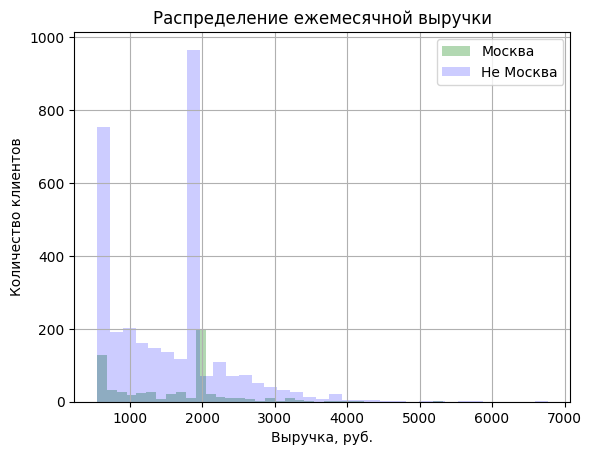

In [34]:
user_behavior[user_behavior['city'] =='Москва']['total_cost'].hist(bins=35, alpha=0.3, color='green')
user_behavior[user_behavior['tariff'] !='Москва']['total_cost'].hist(bins=35, alpha=0.2, color='blue')
plt.legend(['Москва', 'Не Москва'])
plt.xlabel('Выручка, руб.')
plt.ylabel('Количество клиентов')
plt.title('Распределение ежемесячной выручки')
plt.show()

In [35]:
results = st.ttest_ind(user_behavior.query('city == "Москва"')['total_cost'],
                       user_behavior.query('city != "Москва"')['total_cost'],
                       equal_var=False) 

print('Значение p-value:', results.pvalue) 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Значение p-value: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Иначе говоря, с вероятностью 95% нельзя утверждать, что выручка из Москвы превышает выручку из прочих регионов.

## Вывод

Цель проекта состояла в проверке двух гипотез на уровне значимости в 5% для дальнейшего исследования доходности тарифов оператора:

- средняя выручка с пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка с пользователей из Москвы отличается от выручки с пользователей других регионов.

Для проверки были предоставлены данные о звонках, смс и интернет-трафике для 500 пользователей за 2018 г., а также персональная информация о самих пользователях и характеристики тарифов.

Вначале информация была проверена на пригодность для анализа. В результате:
- Информация о датах совершения операции была переведена в формат дат;
- Нерелевантные столбцы были удалены;
- Длительность звонков была округлена вверх и переведена в целочисленный тип (для унификации с методами начисления у оператора).

Затем данные были агрегированы по пользователям и месяцам и объединены с информацией об используемом тарифе. На основе этих данных была расчитана выручка от каждого клиента как ежемесячная плата плюс стоимость всех услуг сверх тарифа.

Далее были проаналированы отличия в пользовательском поведении в зависимости от тарифа: выяснилось, что клиенты "Смарт" в среднем используют меньше минут, смс и Интернета, чем пользователи тарифа "Ультра". Также распределение показателей для тарифа "Смарт" более сконцентрированое, чем для "Ультра".

После статистическими метогдами были проверены выдвинутые гипотезы (см. выше). На основании тестов с вероятностью 95% можно сказать, что выручка от тарифов различается, однако гипотезу о региональных отличиях отвергнуть не удалось.